# Test Training Real waste
## Source :https://archive.ics.uci.edu/dataset/908/realwaste


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import MaxPool2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
# compile model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.applications.efficientnet import preprocess_input



def load_image():
	'''
	Load images from directory

	:param dir: directory of images
	:return: image generator
	'''

	'''
							    horizontal_flip=True,
								vertical_flip=True,
								channel_shift_range=100,
								rotation_range=90,
								validation_split=0.2,'''
	
	dir = 'RealWaste'
	datagen = ImageDataGenerator(rescale=1./255,
    				preprocessing_function=preprocess_input,
					validation_split=0.2,
							)  # Normalize images
	
	train_gen = datagen.flow_from_directory(
		dir,
		target_size=(224, 224),
		batch_size=64,
		class_mode='categorical',
		subset='training',
	)

	val_gen = datagen.flow_from_directory(
		dir,
		target_size=(224, 224),
		batch_size=64,
		class_mode='categorical',
		subset='validation',
	)

	return train_gen, val_gen

def load_fruit_data():
	gen = ImageDataGenerator(
		preprocessing_function=preprocess_input,
		
		)

	train_gen = gen.flow_from_directory(
				'fruits-360/Training',
				target_size=(224,224),
				batch_size=64,
				class_mode='categorical',
				shuffle=True
			)

	val_gen = gen.flow_from_directory(
		'fruits-360/Test',
		target_size=(224, 224),
		batch_size=64,
		class_mode='categorical',
		subset='validation',
	)

	return train_gen, val_gen

def load_model():
    
	base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                   weights='imagenet',
                                                   input_shape=(224, 224, 3))
	base_model.trainable = False  # Freeze the base model


    # Set the entire model's layers to non-trainable
	base_model.trainable = False

	return base_model


def build_model(base_model, output_dim=2):
	'''
	Build a model on top of the base model
	
	:param base_model: base model
	:param output_dim: number of output classes
	:return: model
	'''
	model = base_model.output
	model = GlobalAveragePooling2D()(model)
	model = Flatten()(model)
	model = Dense(output_dim, activation='softmax')(model)


	return model



	

In [2]:
# Load the data for real waste
train_gen, val_gen = load_image()

# Load the data for fruits
#train_gen, val_gen = load_fruit_data()

num_classes = train_gen.num_classes


Found 3803 images belonging to 9 classes.
Found 949 images belonging to 9 classes.


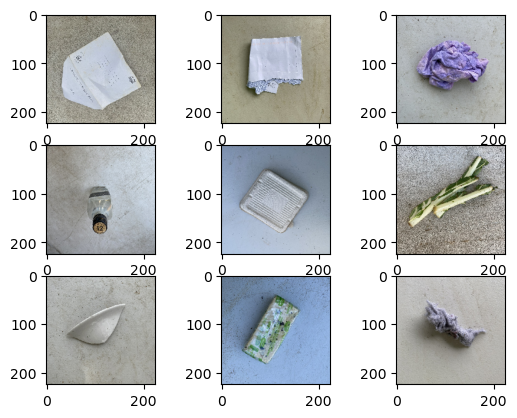

In [3]:
# show one image
import matplotlib.pyplot as plt

for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = train_gen.next()
	image = batch[0][0]
	plt.imshow(image)

In [4]:
#load model
base_model = load_model()
Yhat = build_model(base_model, train_gen.num_classes)

# compile model
model = Model(inputs=base_model.input, outputs=Yhat)

2024-02-07 15:32:44.873906: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-07 15:32:44.873949: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-07 15:32:44.873965: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-07 15:32:44.874318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-07 15:32:44.874767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
!pip install graphviz

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

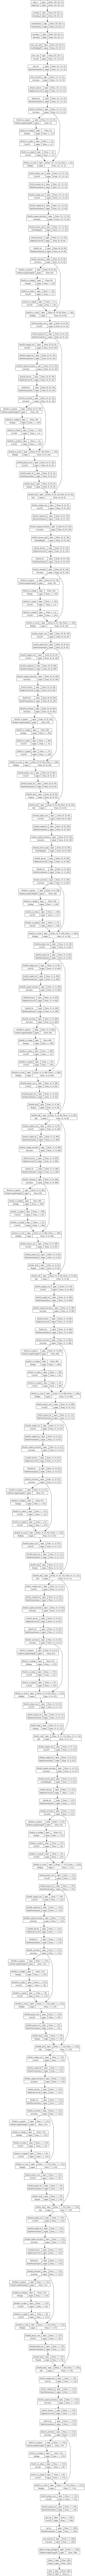

In [6]:
model.summary()
# plot model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [7]:
import tensorflow as tf

initial_learning_rate = 1e-2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)


model.compile(
	optimizer=Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(),
	metrics=['accuracy']
)

# train model
history = model.fit(
	train_gen,
	epochs=20,
	steps_per_epoch=train_gen.samples // train_gen.batch_size,
	validation_data=val_gen,

)

Epoch 1/20


2024-02-07 15:32:55.506040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 47s 724ms/step - loss: 2.3496 - accuracy: 0.1575 - val_loss: 2.1745 - val_accuracy: 0.1054
Epoch 2/20
59/59 [==============================] - 39s 644ms/step - loss: 2.2299 - accuracy: 0.1712 - val_loss: 2.2330 - val_accuracy: 0.1665
Epoch 3/20
59/59 [==============================] - 37s 630ms/step - loss: 2.2414 - accuracy: 0.1514 - val_loss: 2.2437 - val_accuracy: 0.1939
Epoch 4/20
59/59 [==============================] - ETA: 0s - loss: 2.2851 - accuracy: 0.1476

KeyboardInterrupt: 

In [ ]:
# plot loss and accuracy
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

# evaluate model
test_generator = load_image('test')

loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")




In [ ]:
# save model
model.save('model.h5')
